# CS 109A/AC 209A/STAT 121A Data Science: Homework 6
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 2nd, 2016 at 11:59pm

Import libraries

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import discriminant_analysis as da
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Halperin, Keyan]

### Part (b): Course Number

[STATS 121a]

## Problem 1: Recommender System for Movies

In this problem, you will build a model to recommend movies using ratings from users. 

The dataset for this problem is contained in `dataset_4_ratings.txt`. This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `dataset_4_movie_names.txt`.

### Part 1(a): Exploring how to rank

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?


- **Implementation:** Suppose we measure the "goodness" of a movie by the probability that it will be liked by a user, $P(\textbf{label} = \text{like}|\textbf{movie}) = \theta_{\text{movie}}$. Assuming that each user independently rates a given movie according to the probability $\theta_{\text{movies}}$. Use a reasonable estimate of $\theta_{\text{movies}}$ to build a list of top 25 movies that you would recommend to a new user.

   **Hint:** What does the likelihood function, $P(\textbf{likes} = k | \theta_{\text{movie}}, n, \textbf{movie})$, look like? What $\theta_{\text{movie}}$ will maximize the likelihood?
   

- **Analysis:** Why is using $\theta_{\text{movie}}$ to rank movies more appropriate than using the total number of likes? Explain why your estimate of $\theta_{\text{movie}}$ is reasonable. Explain the potential draw backs of estimating $\theta_{\text{movie}}$ this way.

   **Hint:** Under what conditions may models that maximize the likelihood be suboptimal? Do those conditions apply here?   

In [298]:
ratings_df = pd.read_csv('datasets/dataset_4_ratings.txt', delimiter=',')
ratings_df.head()

,user_id,movie_id,rating
0,22.0,377.0,0.0
1,62.0,257.0,0.0
2,95.0,546.0,0.0
3,38.0,95.0,1.0
4,63.0,277.0,1.0


In [299]:
names_df = pd.read_csv('datasets/dataset_4_movie_names.txt', delimiter='|')
names_df.head()

,movie_id,movie_name,release_date,Unnamed: 3,link,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN


In [300]:
#--------  movie_stats
# A function that extracts the number of likes and total number of ratings for a movie
# Input: 
#      movie_name (an optional parameter containing the exact name of the movie)
#      movie_name_contains (an optional parameter containing a portion of the name of the movie)
# Returns: 
#      total_ratings (the total number of ratings for a movie)
#      likes (the total number of likes for a movie)

def movie_stats(movie_name=None, movie_name_contains=None):
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

Using $\theta_{\text{movie}}$ is more appropriate than using the total number of likes because simply using the total number of likes does not take into consideration the amount or proportion of individuals who did not like the movie. 

Estimating $\theta_{\text{movie}}$ by the number of individuals who liked the movie divided by the total number of ratings is a much better method since it incorporates the proportion of individuals who liked the movie. However, it does not incorporate the number of ratings. For example, a movie with 99 likes out of 100 ratings should be considered to be a better movie than a movie with only 2 likes out of 2 ratings because with such a small sample size (n=2), it is difficult to make meaningful inferences about the population.  

In [301]:
#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, likes / total_ratings))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
French Twist (Gazon maudit) (1995) : 1.0 (2.0/2.0)
Exotica (1994) : 1.0 (2.0/2.0)
Three Colors: Red (1994) : 1.0 (12.0/12.0)
Three Colors: White (1994) : 1.0 (8.0/8.0)
Shawshank Redemption, The (1994) : 1.0 (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994) : 1.0 (1.0/1.0)
Carlito's Way (1993) : 1.0 (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994) : 1.0 (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) : 1.0 (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 1.0 (6.0/6.0)
Maya Lin: A Strong Clear Vision (1994) : 1.0 (1.0/1.0)
Unhook the Stars (1996) : 1.0 (1.0/1.0)
Wrong Trousers, The (1993) : 1.0 (14.0/14.0)
Godfather: Part II, The (1974) : 1.0 (18.0/18.0)
Ridicule (1996) : 1.0 (5.0/5.0)
Pillow Book, The (1995) : 1.0 (2.0/2.0)
When the Cats Away (Chacun cherche son chat) (1996) : 1.0 (3.0/3.0)
unknown : 1.0 (2.0/2.0)
Once Upon a Time... When We Were Colored (1995) : 1.0 (2.0/2.0)
Ass

### Part 1(b): Exploring the effect of prior beliefs

Let's add a prior, $p(\theta_{\text{movie}})$, to our probabilistic model for movie rating. To keep things simple, we will restrict ourselves to using beta priors.

- **Analysis:** How might adding a prior to our model benifit us in our specific task? Why are beta distributions appropriate priors for our application?

  **Hint:** Try visualizing beta priors $a = b = 1$, $a = b = 0.5$, $a = b = 2$ and $a = 4, b = 2$, for example, what kind of plain-English prior beliefs about the movie does each beta pdf encode?


- **Implementation/Analysis:** How does the choice of prior affect the posterior distribution of the 'likability' for the movies: *Toy Story, Star Wars, The Shawshank Redemption, Down Periscope and Chain Reaction*.

   **Hint:** Use our posterior sampling function to visualize the posterior distribution.
   
 
- **Implementation/Analysis:** How does the effect of the prior on the posterior distribution vary with the number of user ratings? 

   **Hint:** Visualize the posterior distribution for different sizes of subsample of user ratings for the movie *Star Wars*.
   
In the following, we've provide you a couple of functions for visualize beta priors and approximating their associated posteriors.

In [302]:
#--------  plot_beta_prior
# A function to visualize a beta pdf on a set of axes
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      color (color of beta pdf)
#      ax (axes on which to plot pdf)
# Returns: 
#      ax (axes with plot of beta pdf)

def plot_beta_prior(a, b, color, ax):
    rv = sp.stats.beta(a, b)
    x = np.linspace(0, 1, 100)
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    return ax

Adding a prior to our model would help by penalizing models with fewer ratings based on our prior beliefs of what the distribution of likability scores should look like. 

The Beta distribution is a good choice for our prior since it ranges from 0 to 1, just like our likability score. Additionally, it is a very flexible distribution, i.e. it can take on a wide variety of shapes depending on what our priors beliefs are.  

In [303]:
#--------  sample_posterior
# A function that samples points from the posterior over a movie's 
# likability, given a binomial likelihood function and beta prior
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      likes (the number of likes in likelihood)
#      ratings (total number of ratings in likelihood)
#      n_samples (number of samples to take from posterior)
# Returns: 
#      post_samples (a array of points from the posterior)

def sample_posterior(a, b, likes, ratings, n_samples):
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples

In [304]:
#--------  find_mode
# A function that approximates the mode of a distribution given a sample from the distribution
# Input: 
#      values (samples from the distribution)
#      num_bins (number of bins to use in approximating histogram)
# Returns: 
#      mode (the approximate mode of the distribution)

def find_mode(values, num_bins):
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

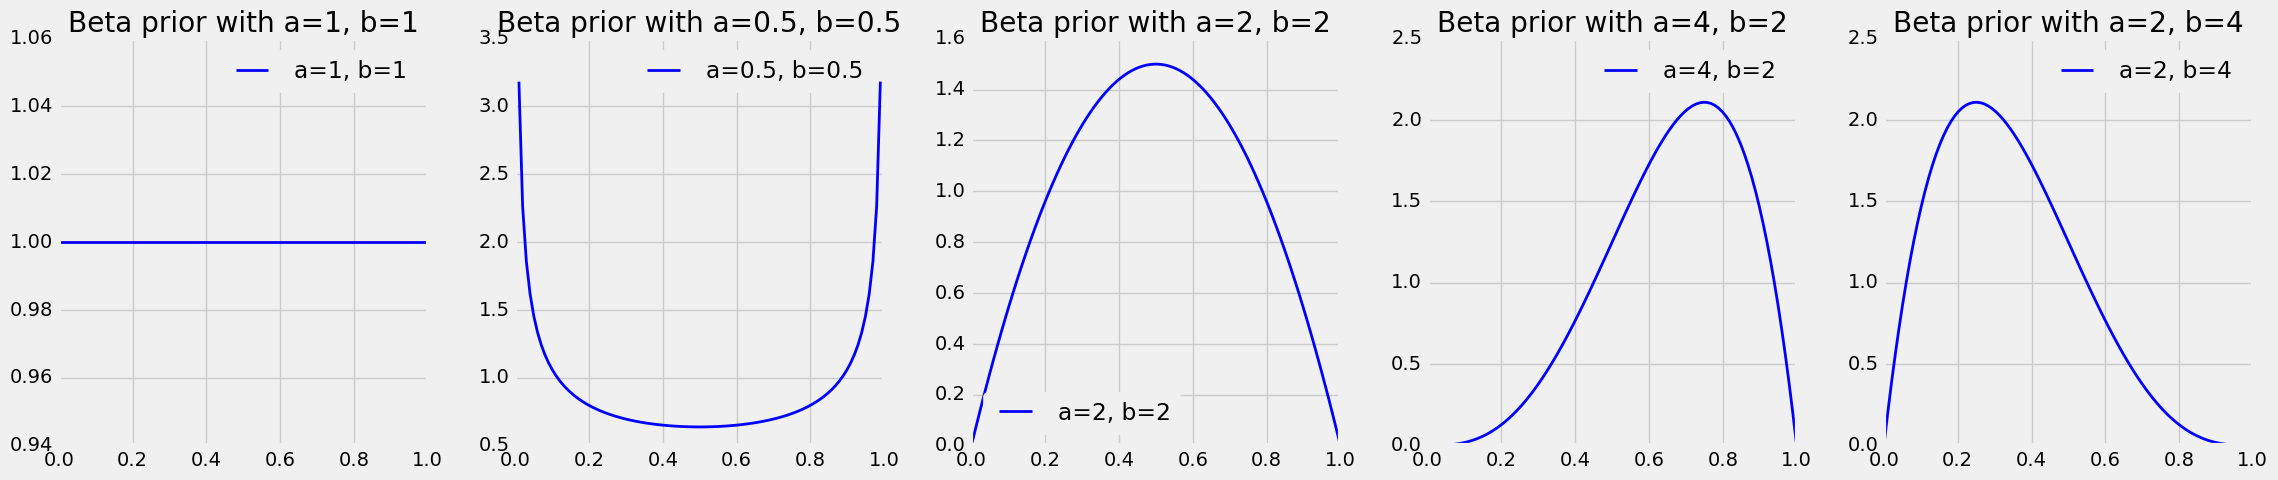

In [305]:
#A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]
#Length of the list of shapes
n = len(beta_shapes)

#Plot all the beta pdfs in a row
matplotlib.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, n, figsize=(23, 5))

#Start the index of the current subplot at 0
ax_ind = 0
#Iterate through all the shapes
for a, b in beta_shapes:
    #Plot the beta pdf for a particular shape
    plot_beta_prior(a, b, 'blue', ax[ax_ind])
    #Increment the subplot index
    ax_ind += 1
    
plt.tight_layout()    
plt.show() 

Toy Story: 0.745098039216 (38.0/51.0)


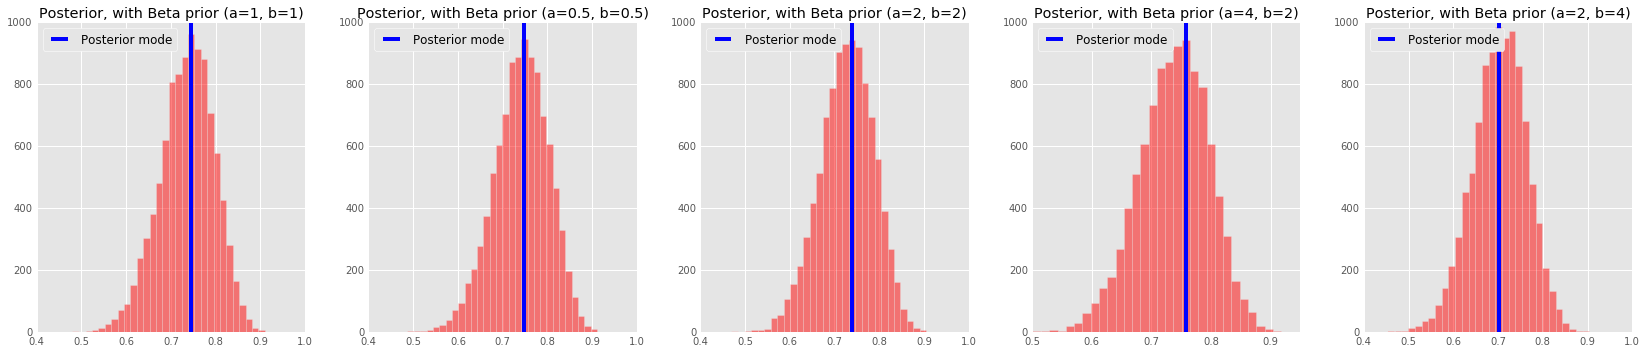

Star Wars: 0.865671641791 (58.0/67.0)


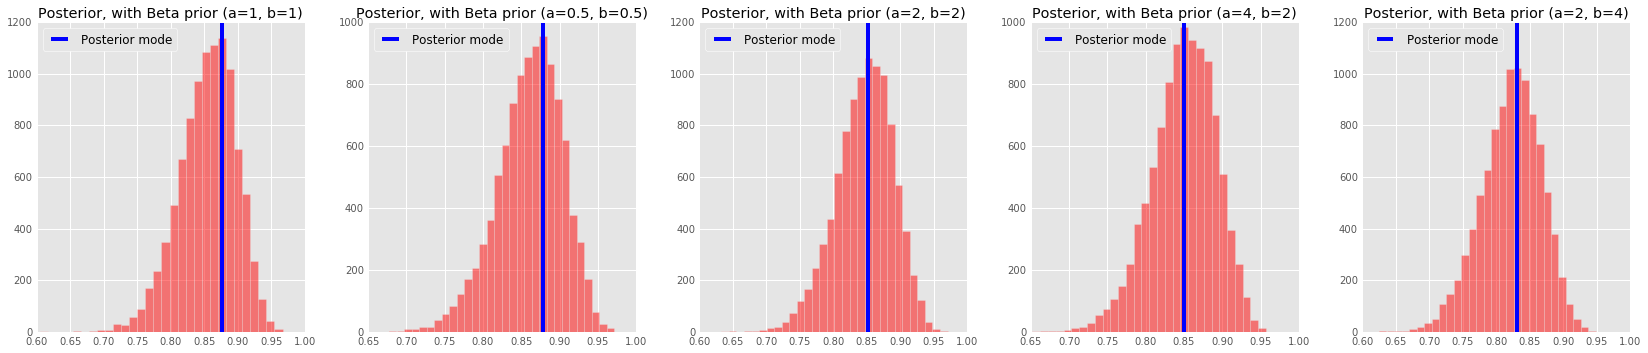

Shawshank Redemption: 1.0 (39.0/39.0)


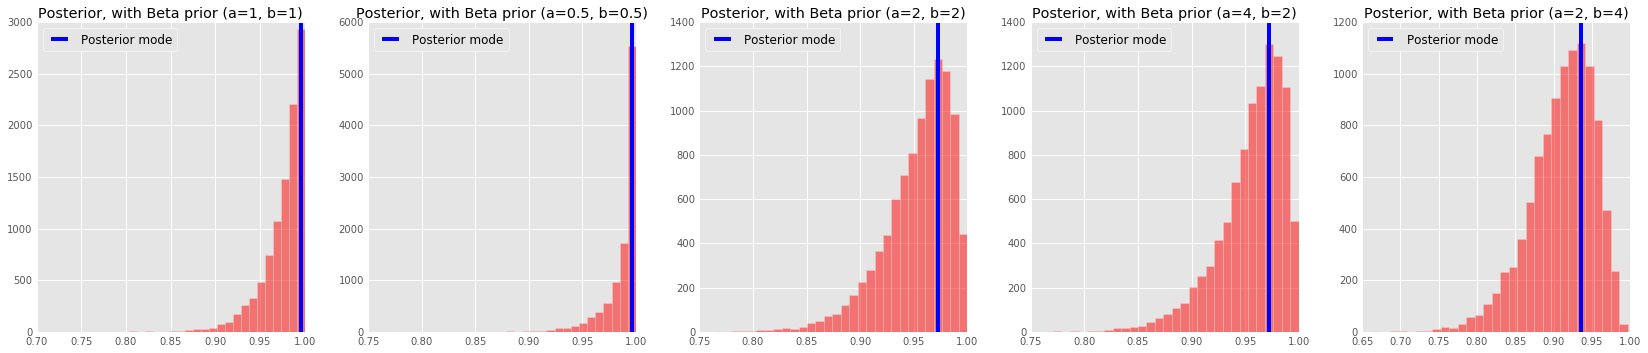

French Twist: 1.0 (2.0/2.0)


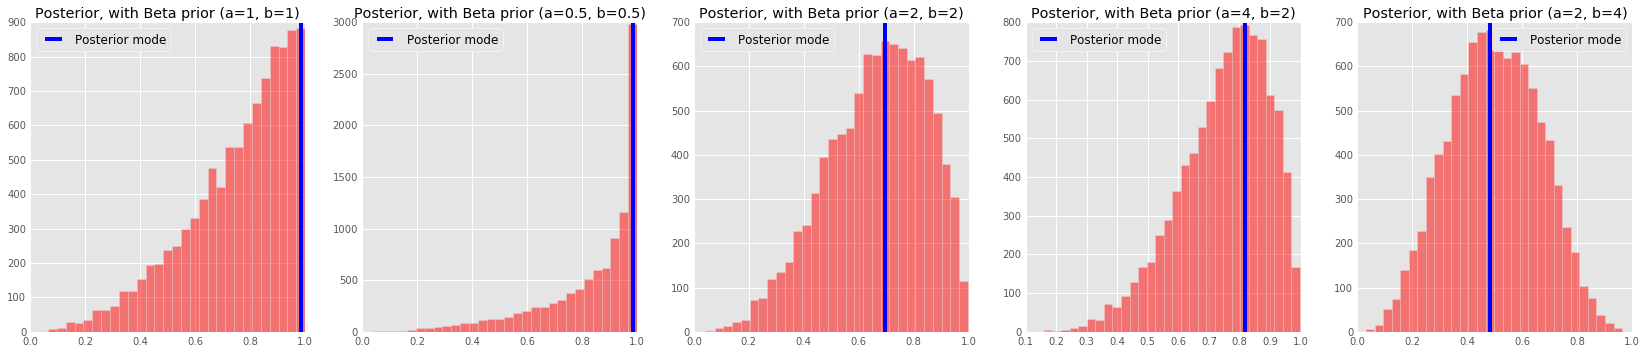

Down Periscope: 0.0666666666667 (1.0/15.0)


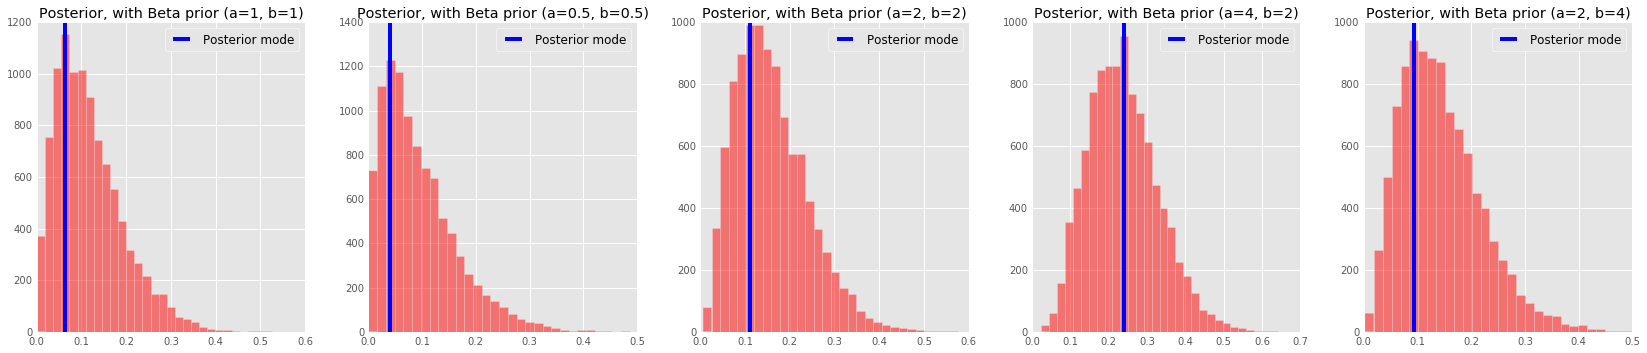

Chain Reaction: 0.0 (0.0/10.0)


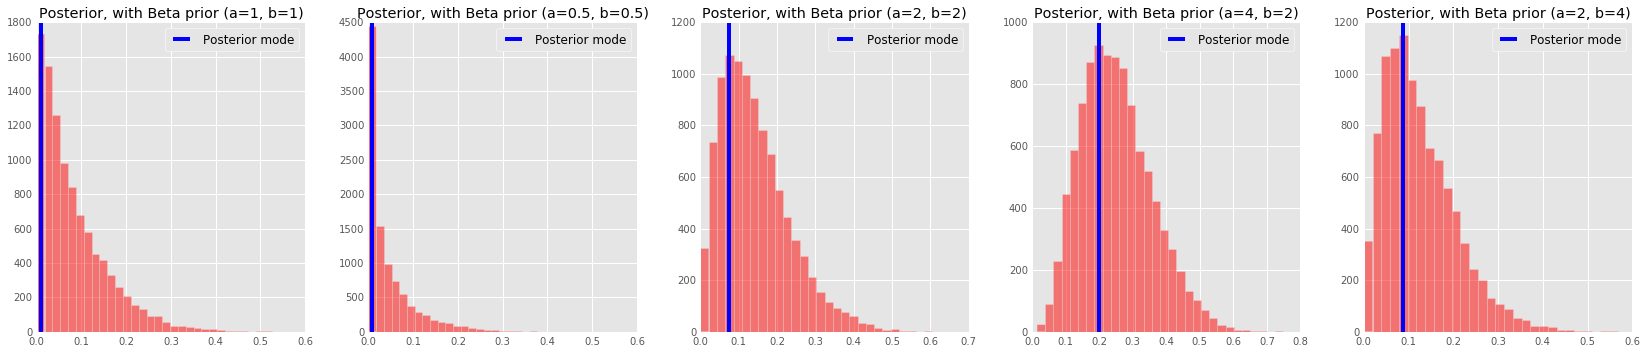

In [517]:
movie_names = ['Toy Story', 'Star Wars', 'Shawshank Redemption', 'French Twist', 'Down Periscope', 'Chain Reaction']

for name in movie_names:
    total_ratings, likes = movie_stats(movie_name_contains = name)
    likability = likes / total_ratings
    
    #Print movie info
    print '{}: {} ({}/{})'.format(name, likability, likes, total_ratings)

    #Number of samples to use when approximating our posterior
    n_samples = 10000

    #Plot the posterior corresponding to each prior
    matplotlib.style.use('ggplot')
    fig, ax = plt.subplots(1, n, figsize=(23, 5))

    #Start the index of the current subplot at 0
    ax_ind = 0

    #Iterate through all the shapes
    for a, b in beta_shapes:   
        #Draw samples from the posterior corresponding to a particular beta prior
        post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
        #Approximate the posterior with a histogram of these samples
        ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
        #Find the approximate mode of the posterior
        mode = find_mode(post_samples, 30)
        #Plot the mode as a vertical line
        ax[ax_ind].axvline(x=mode, linewidth=4, label='Posterior mode')
    
        #Set title, legends etc
        ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
        ax[ax_ind].legend(loc='best')
        #Increment the subplot index
        ax_ind += 1

    plt.tight_layout()
    plt.show() 

As we can see from the histograms of the posterior distribution, the MAP estimate of $\theta_{\text{movie}}$ varies according to both the choice of prior as well as the number of user ratings. Certain priors, like the uniform, do not change our estimate very much (or at all). However, when looking at the Beta prior with $a=b=2$, we can see that movies with a small number of ratings are penalized. For example, both Shawshank Redemption and The French Twist have 100% likability, but when adding the prior, we can see that Shawshank remains very high, with an estimated $\theta_{\text{movie}}$ of about .98, while The French Twist has an estimated $\theta_{\text{movie}}$ of only about .7.

### Part 1(c): Recommendation based on ranking

- **Implementation:** Choose a reasonable beta prior, choose a reasonable statistic to compute from the posterior, and then build a list of top 25 movies that you would recommend to a new user based on your chosen posterior statistic.  

 
- **Analysis:** How does your top 25 movies compare with the list you obtained in part(a)? Which method of ranking is better?

 
- **Analysis:** So far, our estimates of the 'likability' for a movie was based on the ratings provided by all users. What can be the draw back of this method? How can we improve the recommender system for individual users (if you feel up to the challenge, implement your improved system and compare it to the one you built in the above)? 

In [294]:
#Choose a beta prior that encodes a reasonable belief about likability 
a = 2 
b = 2

#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Approximate the posterior given the ratings info and the prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate posterior mode
    mode = find_mode(post_samples, 30)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, mode))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', round(likable, 5), '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
Shawshank Redemption, The (1994) : 0.97574 (39.0/39.0)
Cool Hand Luke (1967) : 0.95232 (20.0/20.0)
Glory (1989) : 0.95028 (17.0/17.0)
Godfather: Part II, The (1974) : 0.94761 (18.0/18.0)
Manchurian Candidate, The (1962) : 0.94739 (17.0/17.0)
Raiders of the Lost Ark (1981) : 0.94079 (47.0/49.0)
Wrong Trousers, The (1993) : 0.93983 (14.0/14.0)
Killing Fields, The (1984) : 0.93714 (14.0/14.0)
Three Colors: Red (1994) : 0.93663 (12.0/12.0)
Casablanca (1942) : 0.93467 (22.0/23.0)
Three Colors: White (1994) : 0.92047 (8.0/8.0)
East of Eden (1955) : 0.9196 (8.0/8.0)
Local Hero (1983) : 0.91744 (10.0/10.0)
High Noon (1952) : 0.9115 (11.0/11.0)
This Is Spinal Tap (1984) : 0.90916 (24.0/26.0)
Close Shave, A (1995) : 0.90787 (16.0/17.0)
Vertigo (1958) : 0.90423 (22.0/23.0)
Dead Man Walking (1995) : 0.90192 (33.0/36.0)
Alien (1979) : 0.90052 (28.0/30.0)
Chinatown (1974) : 0.89772 (14.0/15.0)
Treasure of the Sierra Madre, The (1948) : 0.89687 (15.0/16.0)
H

As mentioned before, when looking at the Beta prior with $a=b=2$, we can see that movies with a small number of ratings are penalized. And so we no longer have movies in the top 25 that only have 2 ratings. As a result, this top 25 list is much better than the previous one.

However, one draw back of this method is that we are assinging every individual the same probability of liking each movie. If we incorporated individual's preferences into the model by, we could potentially get more accurate estimates. One way we could do that is by grouping users into different categories based on their prefernces, and then have a different set of $\theta_{\text{movie}}$ estimates for each group.  

---

## Problem 2: Predicting Urban Demographic Changes

### Part 2(a): Temporal patterns in urban demographics

In this problem you'll work with some neighborhood demographics of a region in Boston from the years 2000 to 2010. 

The data you need are in the files `dataset_1_year_2000.txt`, ..., `dataset_1_year_2010.txt`. The first two columns of each dataset contain the adjusted latitude and longitude of some randomly sampled houses. The last column contains economic status of a household: 

0: low-income, 

1: middle-class, 

2: high-income 

Due to the migration of people in and out of the city, the distribution of each economic group over this region changes over the years. The city of Boston estimates that in this region there is approximately a 25% yearly increase in high-income households; and a 25% decrease in the remaining population, with the decrease being roughly the same amongst both the middle class and lower income households.

Your task is to build a model for the city of Boston that is capable of predicting the economic status of a household based on its geographical location. Furthermore, your method of prediction must be accurate over time (through 2010 and beyond). 

**Hint:** look at data only from 2000, and consider using both Linear Discriminant Analysis (LDA) and Logistic Regression. Is there a reason one method would more suited than the other for this task?

**Hint:** how well do your two models do over the years? Is it possible to make use of the estimated yearly changes in proportions of the three demographic groups to improve the predictive accuracy of each models over the years? 

To help you visually interpret and assess the quality of your classifiers, we are providing you a function to visualize a set of data along with the decision boundaries of a classifier.

In [4]:
# Load data
data_00 = np.loadtxt('datasets/dataset_1_year_2000.txt')
print 'n =', len(data_00)

# Split predictors and response
x_00 = data_00[:, 0:2]
y_00 = data_00[:, 2]

pd.DataFrame(data_00).head()

n = 1000


,0,1,2
0,0.544328,0.624510,2.0
1,0.594685,0.723913,2.0
2,0.700180,0.782492,2.0
3,0.601262,0.971812,2.0
4,0.631995,0.748502,2.0


In [5]:
#Since we only have two predictors, both of which are important, regularization should not be necessary.
logit = linear_model.LogisticRegression(C=100000000000)
logit.fit(x_00, y_00)

lda = da.LinearDiscriminantAnalysis()
lda.fit(x_00, y_00)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [6]:
def plot_decision_boundary(x, y, model, poly_flag, title, ax):
    
    # Plot data
    upper = ax.scatter(x[y == 2, 0], x[y == 2, 1], c='red', alpha=.8)
    middle = ax.scatter(x[y == 1, 0], x[y == 1, 1], c='lime')
    lower = ax.scatter(x[y == 0, 0], x[y == 0, 1], c='deepskyblue')
    
    ax.legend((upper, middle, lower), ("Upper Class", "Middle Class", "Lower Class"), prop={'size': 15}, loc=1)
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1)
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

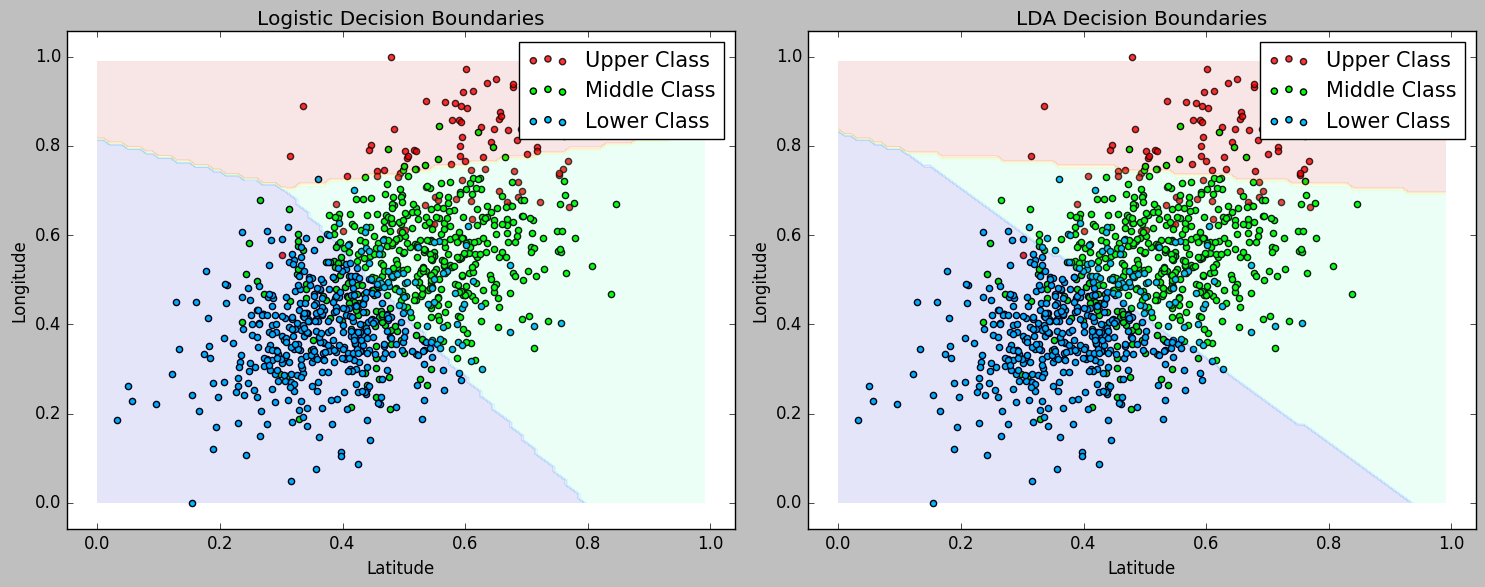

LDA Overall Accuracy: 0.792
Logistic Overall Accuracy: 0.781


In [10]:
matplotlib.style.use('default')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

plot_decision_boundary(x_00, y_00, model=logit, poly_flag=False, title='Logistic Decision Boundaries', ax=ax1)
plot_decision_boundary(x_00, y_00, model=lda, poly_flag=False, title='LDA Decision Boundaries', ax=ax2)

plt.tight_layout()
plt.show()  

print "LDA Overall Accuracy:", lda.score(x_00,y_00)
print "Logistic Overall Accuracy:", logit.score(x_00,y_00)

As we can see from the plots of the decion boundaries, as well as the overall accuracy, both LDA and Logistic Regression seem to do a reasonably good job at predicting class based on location. However, we are more interested in seeing how well our model does over time.

In [523]:
data_list = ['datasets/dataset_1_year_2001.txt', 'datasets/dataset_1_year_2002.txt', 'datasets/dataset_1_year_2003.txt', 
             'datasets/dataset_1_year_2004.txt', 'datasets/dataset_1_year_2005.txt', 'datasets/dataset_1_year_2006.txt', 
             'datasets/dataset_1_year_2007.txt', 'datasets/dataset_1_year_2008.txt', 'datasets/dataset_1_year_2009.txt', 
             'datasets/dataset_1_year_2010.txt']

logit_accuracy = []
lda_accuracy = []

for i in range(len(data_list)):
    
    # Load data
    data = np.loadtxt(data_list[i])

    # Split predictors and response
    x = data[:, 0:2]
    y = data[:, 2]
    
    #Calculate accuracy for each year
    logit_accuracy.append(logit.score(x, y))
    lda_accuracy.append(lda.score(x, y))

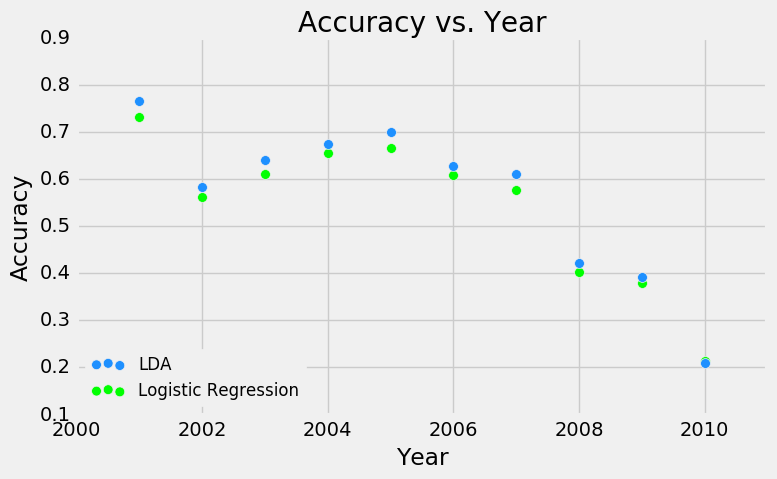

In [524]:
year = range(2001, 2011)

matplotlib.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(8, 5))
logit_plot = ax.scatter(year, logit_accuracy, c='lime', s=50 )
lda_plot = ax.scatter(year, lda_accuracy, c='dodgerblue', s=50 )
ax.legend((lda_plot, logit_plot), ("LDA", "Logistic Regression"), prop={'size': 12}, loc=3)
ax.set_title('Accuracy vs. Year') 
ax.set_xlabel('Year')
ax.set_ylabel('Accuracy')
plt.xlim(2000, 2011)

plt.tight_layout()
plt.show()  

As we can see, our model is getting worse over time since we are not incorporating the estimated yearly change in each class. Let's try to do that now.

In [525]:
lda2_accuracy = []
y0_accuracy = []
y1_accuracy = []
y2_accuracy = []

y0_2000 = len(y_00[y_00==0])
y1_2000 = len(y_00[y_00==1])
y2_2000 = len(y_00[y_00==2])
ytotal_2000 = len(y_00)

for i in range(len(data_list)):
    
    # Load data
    data = np.loadtxt(data_list[i])

    # Split predictors and response
    x = data[:, 0:2]
    y = data[:, 2]
    
    # Find the estimated number of individuals in each class based on the expected changes
    new0 = y0_2000 * (.75**(i+1))
    new1 = y1_2000 * (.75**(i+1))
    new2 = y2_2000 * (1.25**(i+1))
    new_total = new0 + new1 + new2
    
    # Scale probabilities according to estimated proportion for each class
    r = ytotal_2000/new_total
    
    f0 = r*(new0/y0_2000) 
    f1 = r*(new1/y1_2000)
    f2 = r*(new2/y2_2000)
    
    predicted = lda.predict_proba(x)
    prob_0 = predicted[:,0] * f0
    prob_1 = predicted[:,1] * f1
    prob_2 = predicted[:,2] * f2
    
    #Classify each observation according to which probability is the largest.
    pred_y = []
    for i in range(len(prob_0)):
        probs = np.transpose(np.matrix([prob_0, prob_1, prob_2]))
        max_index = np.argmax(probs[i,:])
        pred_y.append(max_index)
        pred_y_array = np.array(pred_y)
    
    #Find overall accuracy
    lda2_accuracy.append( np.sum(pred_y == y)/(float(len(y))) )
    
    #Find accuracy for each class
    y0_accuracy.append( np.sum(pred_y_array[y==0] == y[y==0])/(float(len(y[y==0]))) )
    y1_accuracy.append( np.sum(pred_y_array[y==1] == y[y==1])/(float(len(y[y==1]))) )
    y2_accuracy.append( np.sum(pred_y_array[y==2] == y[y==2])/(float(len(y[y==2]))) )

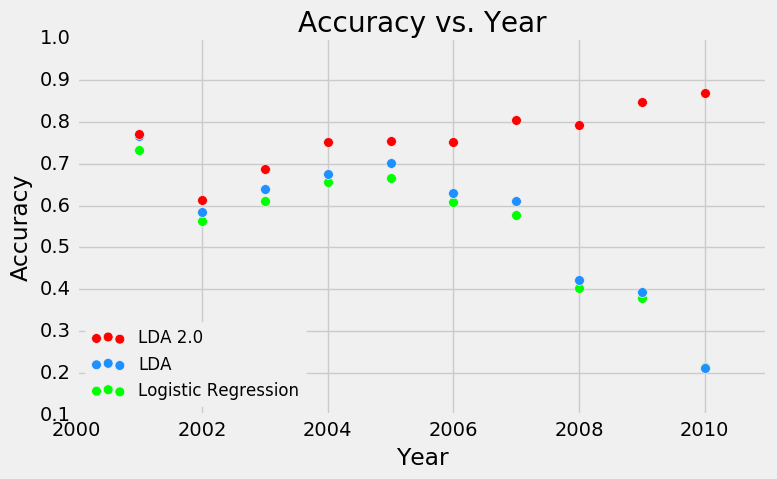

In [526]:
fig, ax = plt.subplots(figsize=(8, 5))
logit_plot = ax.scatter(year, logit_accuracy, c='lime', s=50 )
lda_plot = ax.scatter(year, lda_accuracy, c='dodgerblue', s=50 )
lda2_plot = ax.scatter(year, accuracy, c='red', s=50 )
ax.legend((lda2_plot, lda_plot, logit_plot), ("LDA 2.0","LDA", "Logistic Regression"), 
          prop={'size': 12}, loc=3)
ax.set_title('Accuracy vs. Year') 
ax.set_xlabel('Year')
ax.set_ylabel('Accuracy')
plt.xlim(2000, 2011)

plt.tight_layout()
plt.show()  

Our new model (which I call LDA 2.0) clearly does a much better job at predicting class based on location after incorporating the estimated yearly change for each class. However, we should further assess the quality of our model by seeing how well the model does at predicting each class. 

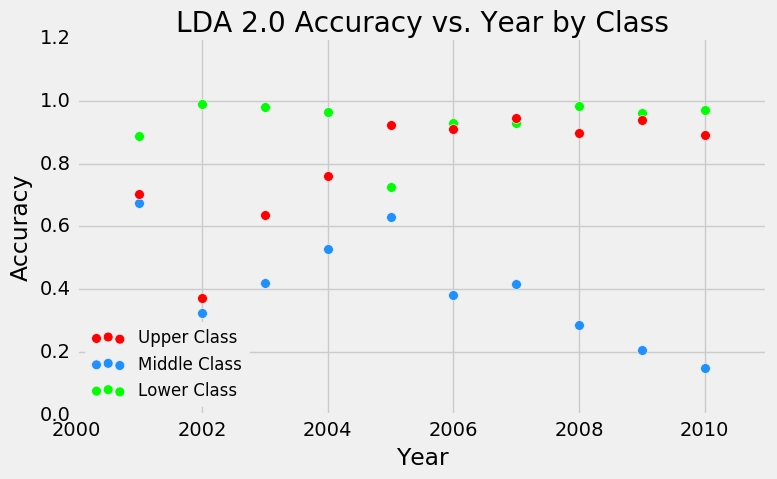

In [527]:
fig, ax = plt.subplots(figsize=(8, 5))
y0 = ax.scatter(year, y0_accuracy, c='lime', s=50 )
y1 = ax.scatter(year, y1_accuracy, c='dodgerblue', s=50 )
y2 = ax.scatter(year, y2_accuracy, c='red', s=50 )
ax.legend((y2, y1, y0), ("Upper Class","Middle Class", "Lower Class"), prop={'size': 12}, loc=3)
ax.set_title('LDA 2.0 Accuracy vs. Year by Class') 
ax.set_xlabel('Year')
ax.set_ylabel('Accuracy')
plt.xlim(2000, 2011)

plt.tight_layout()
plt.show()  

In [531]:
lower_2010 = len(y[y==0])/float(len(y))
middle_2010 = len(y[y==1])/float(len(y))
upper_2010 = len(y[y==2])/float(len(y))

print 'Proportion of individuals in Lower Class in 2010:', round(lower_2010, 3)
print 'Proportion of individuals in Middle Class in 2010:', round(middle_2010, 3)
print 'Proportion of individuals in Upper Class in 2010:', round(upper_2010, 3)

Proportion of individuals in Lower Class in 2010: 0.034
Proportion of individuals in Middle Class in 2010: 0.034
Proportion of individuals in Upper Class in 2010: 0.932


Although our model does not do a great job at predicting the middle class in the later years, this is not too much of a problem since the group is very small. In fact, only 3% of individuals are in the middle class in 2010.   

As a result, we have enough evidence to suggest that our new and improved model does a good job at extrapolating into the future based on the 200 data. 

### Part 2(b): Geographic patterns in urban demographics

In `dataset_2.txt` and `dataset_3.txt` you have the demographic information for a random sample of houses in two regions in Cambridge. There are only two economic brackets for the households in these datasets: 

0: low-income or middle-class, 

1 - high-income. 

For each region, recommend a classification model, chosen from all the ones you have learned, that is most appropriate for classifying the demographics of households in the region.

**Hint:** Support your answers with both numerical and visual analysis.

In [536]:
# Load data
data2 = np.loadtxt('datasets/dataset_2.txt')
print 'n =', len(data2)

# Split predictors and response
x2 = data2[:, 0:2]
y2 = data2[:, 2]

pd.DataFrame(data2).head()

n = 2000


,0,1,2
0,0.542866,0.433326,1.0
1,0.512297,0.491020,1.0
2,0.620624,0.303222,1.0
3,0.620553,0.478634,1.0
4,0.437379,0.418034,1.0


In [537]:
c = 1000000
logit = sk.linear_model.LogisticRegression(C=c)
lda = da.LinearDiscriminantAnalysis()
qda = da.QuadraticDiscriminantAnalysis()

logit.fit(x2, y2)
lda.fit(x2, y2)
qda.fit(x2, y2)

logit.scores = sk.cross_validation.cross_val_score(logit, x2, y2, cv=5)
print 'Logistic Regression Accuracy:', logit.scores.mean()

lda.scores = sk.cross_validation.cross_val_score(lda, x2, y2, cv=5)
print '\nLDA Accuracy:', lda.scores.mean()

qda.scores = sk.cross_validation.cross_val_score(qda, x2, y2, cv=5)
print '\nQDA Accuracy:', qda.scores.mean()


knn_accuracy = []
for k in range(1, 50):
    knn = KNeighborsClassifier(k)
    knn.scores = sk.cross_validation.cross_val_score(knn, x2, y2, cv=5)
    knn_accuracy.append(knn.scores.mean())

knn_accuracy_array = np.array(knn_accuracy)
print '\nKNN Accuracy:', np.max(knn_accuracy_array)
print 'Optimal Value of K:', np.argmax(knn_accuracy_array) + 1

Logistic Regression Accuracy: 0.7475

LDA Accuracy: 0.746

QDA Accuracy: 0.7795

KNN Accuracy: 0.773
Optimal Value of K: 39


In [475]:
def plot_decision_boundary(x, y, model, poly_flag, title, ax):
    # Plot data
    lower_middle = ax.scatter(x[y == 1, 0], x[y == 1, 1], c='red', alpha=.75)
    upper = ax.scatter(x[y == 0, 0], x[y == 0, 1], c='blue', alpha=.75)
    ax.legend((upper, lower_middle), ("Upper Class", "Middle & Lower Class"), prop={'size': 16}, loc=1)
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1)
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

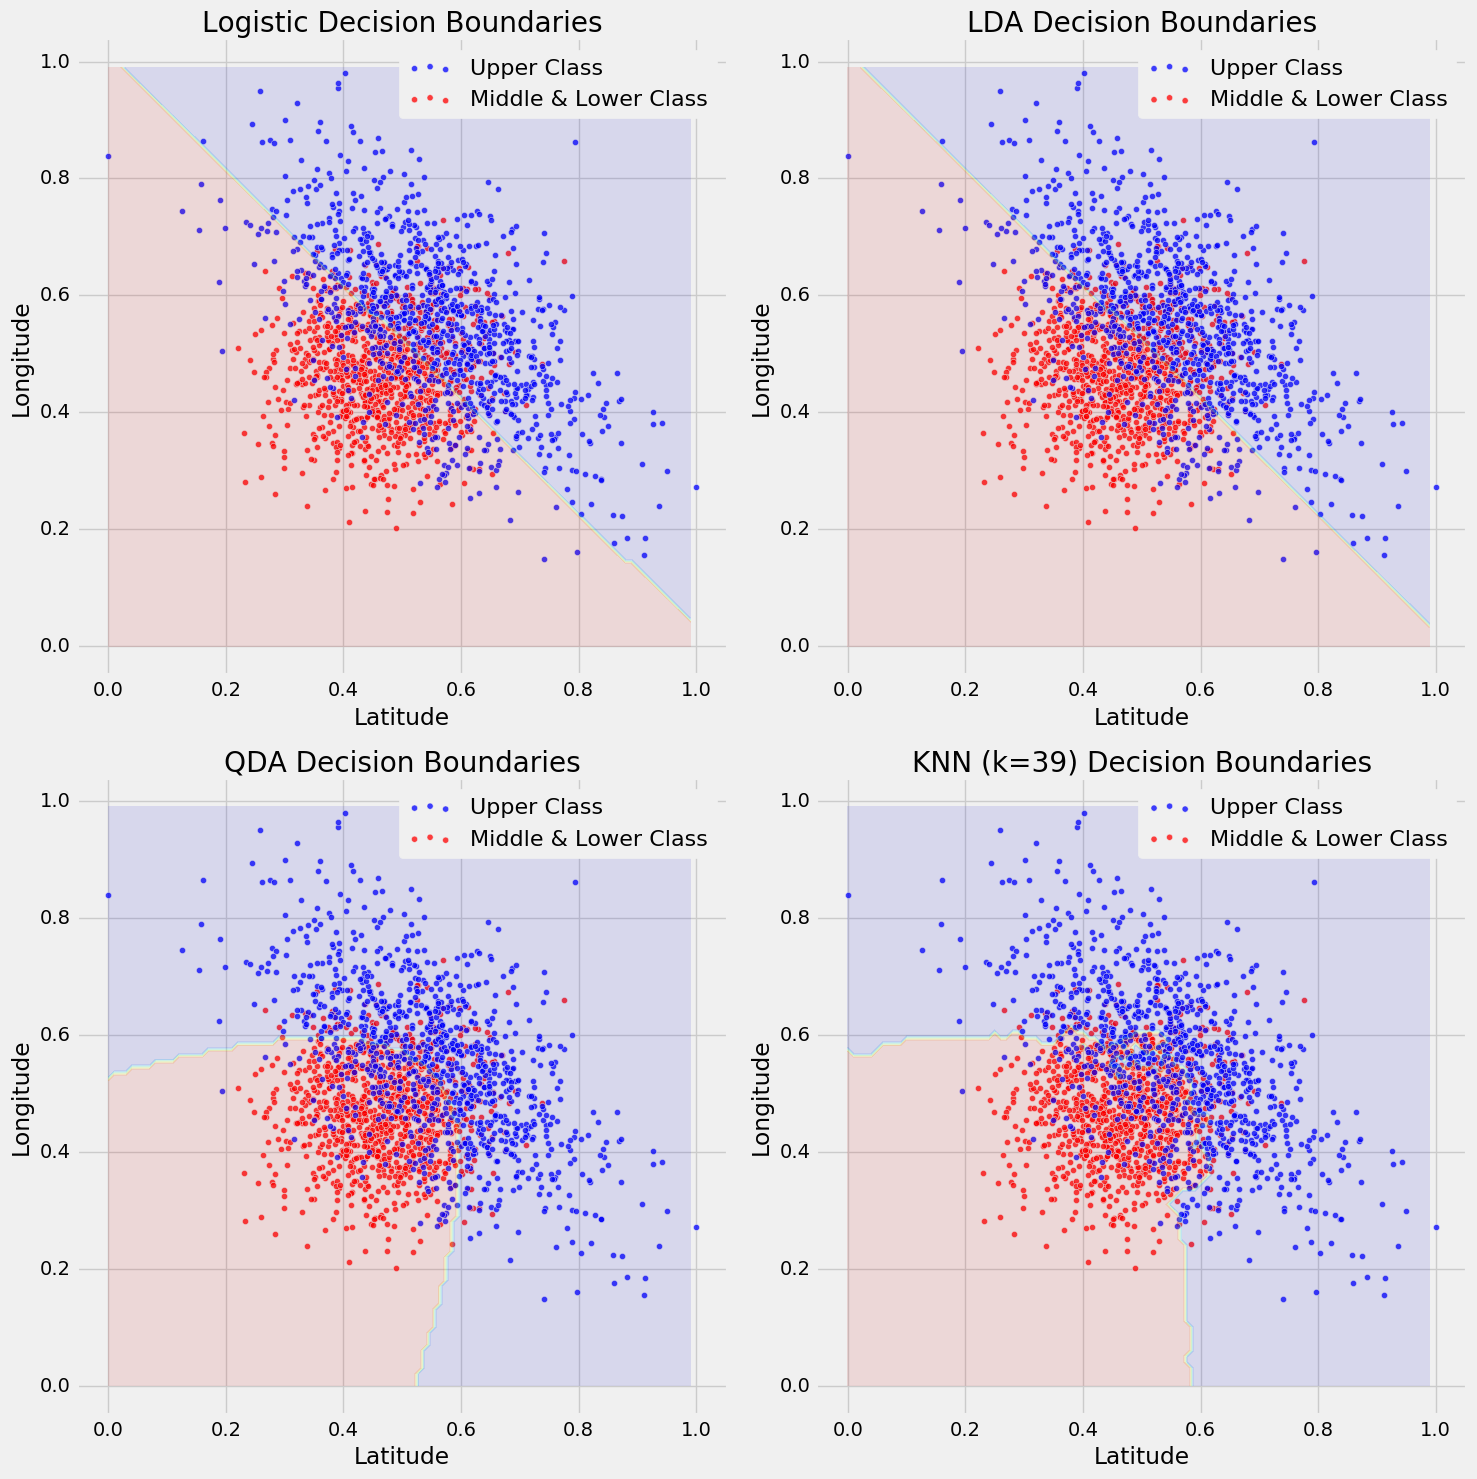

In [489]:
knn = KNeighborsClassifier(39)
knn.fit(x2, y2)

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(15, 15))

plot_decision_boundary(x2, y2, model=logit, poly_flag=False, title='Logistic Decision Boundaries', ax=ax1)
plot_decision_boundary(x2, y2, model=lda, poly_flag=False, title='LDA Decision Boundaries', ax=ax2)
plot_decision_boundary(x2, y2, model=qda, poly_flag=False, title='QDA Decision Boundaries', ax=ax3)
plot_decision_boundary(x2, y2, model=knn, poly_flag=False, title='KNN (k=39) Decision Boundaries', ax=ax4)

plt.tight_layout()
plt.show()  

In [538]:
print 'QDA Accuracy:', qda.scores.mean()

print '\nKNN Accuracy:', np.max(knn_accuracy_array)

QDA Accuracy: 0.7795

KNN Accuracy: 0.773


Based on both the decision boundaries as well as the accuracy, KNN (with k=39) and QDA both do a reasonably good job. Logistic regression and LDA do not do as well since they have linear decision boundaries. But since QDA is more computationally efficient, we would recommend QDA.

In [541]:
# Load data
data3 = np.loadtxt('datasets/dataset_3.txt')
print 'n =', len(data3)

# Split predictors and response
x3 = data3[:, 0:2]
y3 = data3[:, 2]

pd.DataFrame(data3).head()

n = 2000


,0,1,2
0,0.126227,0.846415,1.0
1,0.115902,0.886631,1.0
2,0.139295,0.794580,1.0
3,0.123552,0.832449,1.0
4,0.163855,0.824699,1.0


In [542]:
c = 1000000
logit = sk.linear_model.LogisticRegression(C=c)
lda = da.LinearDiscriminantAnalysis()
qda = da.QuadraticDiscriminantAnalysis()

logit.fit(x3, y3)
lda.fit(x3, y3)
qda.fit(x3, y3)

logit.scores = sk.cross_validation.cross_val_score(logit, x3, y3, cv=5)
print 'Logistic Regression Accuracy:', logit.scores.mean()

lda.scores = sk.cross_validation.cross_val_score(lda, x3, y3, cv=5)
print '\nLDA Accuracy:', lda.scores.mean()

qda.scores = sk.cross_validation.cross_val_score(qda, x3, y3, cv=5)
print '\nQDA Accuracy:', qda.scores.mean()

knn_accuracy = []

for k in range(1, 50):
    knn = KNeighborsClassifier(k)
    knn.scores = sk.cross_validation.cross_val_score(knn, x3, y3, cv=5)
    knn_accuracy.append(knn.scores.mean())

knn_accuracy_array = np.array(knn_accuracy)
print '\nOptimal Value of K:', np.argmax(knn_accuracy_array) + 1
print 'KNN Accuracy:', np.max(knn_accuracy_array) 
#print knn_accuracy

Logistic Regression Accuracy: 0.4545

LDA Accuracy: 0.454

QDA Accuracy: 0.983

Optimal Value of K: 1
KNN Accuracy: 1.0


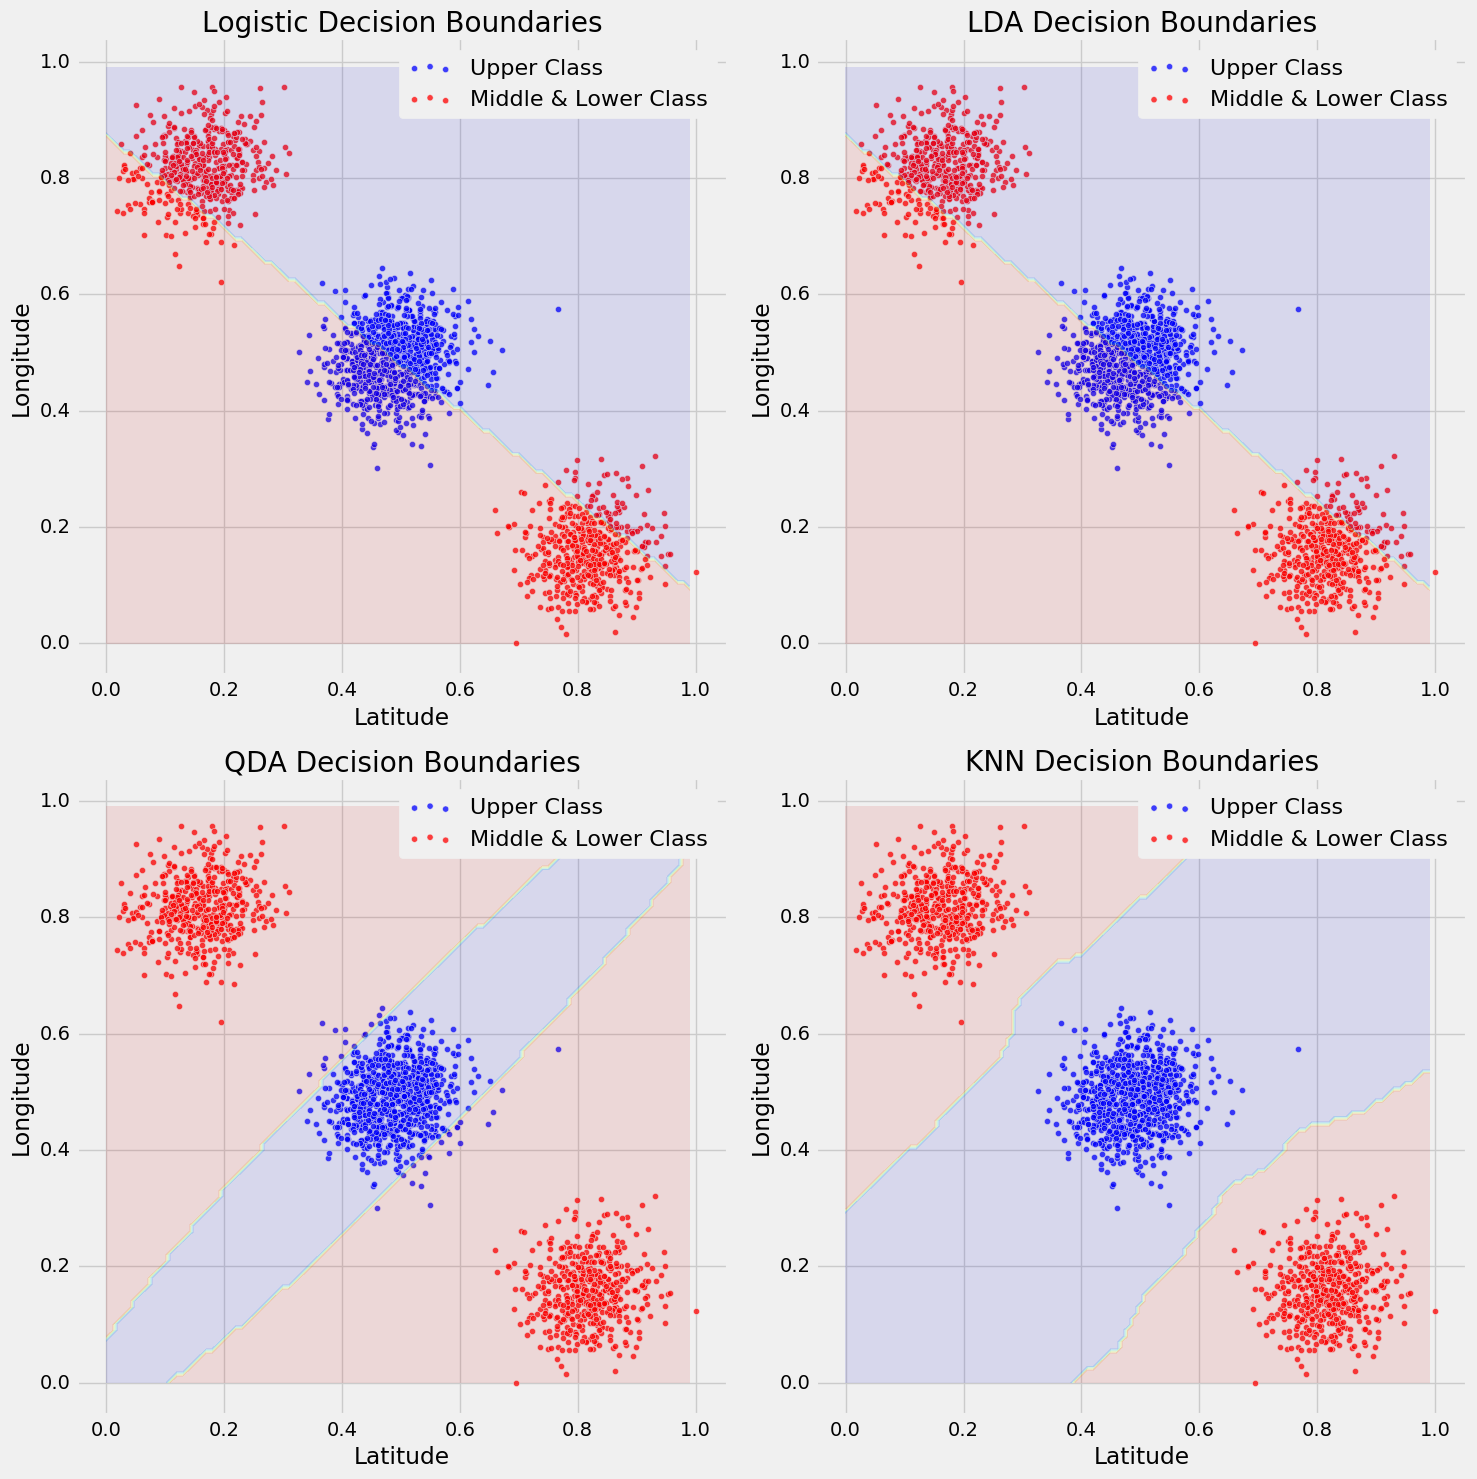

In [493]:
knn = KNeighborsClassifier(1)
knn.fit(x3, y3)

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(15, 15))

plot_decision_boundary(x3, y3, model=logit, poly_flag=False, title='Logistic Decision Boundaries', ax=ax1)
plot_decision_boundary(x3, y3, model=lda, poly_flag=False, title='LDA Decision Boundaries', ax=ax2)
plot_decision_boundary(x3, y3, model=qda, poly_flag=False, title='QDA Decision Boundaries', ax=ax3)
plot_decision_boundary(x3, y3, model=knn, poly_flag=False, title='KNN Decision Boundaries', ax=ax4)

plt.tight_layout()
plt.show()  

In [543]:
print 'KNN Accuracy:', np.max(knn_accuracy_array) 

KNN Accuracy: 1.0


Based on both the decision boundaries as well as the accuracy, KNN does the best job. In fact, KNN has 100% accuracy for all reasonable values of K. QDA also does very well (accuracy = .98), but it is not quite as good. Logistic regression (accuracy = .45) and LDA (accuracy = .45) both do poorly since they require linear decision boundaries.

---